In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [2]:
# Loading the dataset
url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"
data = pd.read_csv(url)

In [3]:
#maintaining only the specified columns
selected_columns = [
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg',
    'MSRP'
]

In [4]:
data = data[selected_columns]

In [5]:
# Lowercase the column names and replacing the spaces with underscores
data.columns = data.columns.str.lower().str.replace(' ', '_')

In [6]:
# Replacing all missing values with 0
data = data.fillna(0)

In [7]:
# Making the price binary (1 if above the average, else 0)
data['above_average'] = (data['msrp'] > data['msrp'].mean()).astype(int)

In [8]:
# Splitting the data into train/validation/test sets as required
train, test = train_test_split(data, test_size=0.2, random_state=1)
train, val = train_test_split(train, test_size=0.25, random_state=1)

In [9]:
# Defining the numerical variables
numerical_vars = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [10]:
# Evaluating AUC for each numerical variable
for var in numerical_vars:
    auc = roc_auc_score(train['above_average'], train[var])
    # Inverting the variable if AUC is < 0.5
    if auc < 0.5:
        auc = roc_auc_score(train['above_average'], -train[var])
    
    print(f'AUC for {var}: {auc}')

AUC for engine_hp: 0.9171031265539011
AUC for engine_cylinders: 0.766116490165669
AUC for highway_mpg: 0.6330587871772013
AUC for city_mpg: 0.6734244643245233


In [11]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Define categorical variables
categorical_vars = ['make', 'model', 'year', 'transmission_type', 'vehicle_style']

# Ensure the specified categorical variables are present in the DataFrame
missing_vars = set(categorical_vars) - set(train.columns)
if missing_vars:
    raise ValueError(f"The following categorical variables are not present in the DataFrame: {missing_vars}")

# Apply one-hot-encoding using DictVectorizer
dv = DictVectorizer(sparse=False)
train_dict = train[categorical_vars].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = val[categorical_vars].to_dict(orient='records')
X_val = dv.transform(val_dict)

# Train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, train['above_average'])

# Predict probabilities on the validation set
val_preds = model.predict_proba(X_val)[:, 1]

# Calculate AUC on the validation dataset
auc = roc_auc_score(val['above_average'], val_preds)

print(f'AUC on the validation dataset: {round(auc, 3)}')


AUC on the validation dataset: 0.962


In [12]:
data.head(2)

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


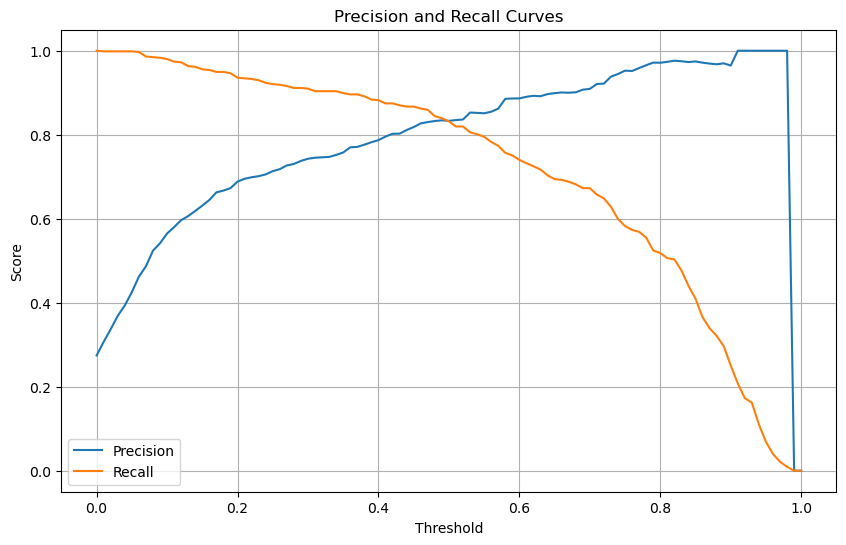

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score

# Define a range of thresholds
thresholds = np.arange(0.0, 1.01, 0.01)

# Initialize empty lists to store precision and recall values
precision_values = []
recall_values = []

# Evaluate the model for each threshold
for threshold in thresholds:
    # Apply the threshold to convert probabilities to binary predictions
    binary_preds = (val_preds > threshold).astype(int)
    
    # Compute precision and recall
    precision = precision_score(val['above_average'], binary_preds)
    recall = recall_score(val['above_average'], binary_preds)
    
    # Append values to the lists
    precision_values.append(precision)
    recall_values.append(recall)

# Plot precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_values, label='Precision')
plt.plot(thresholds, recall_values, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision and Recall Curves')
plt.grid(True)
plt.show()

In [14]:
from sklearn.metrics import f1_score

# Initialize an empty list to store F1 scores
f1_scores = []

# Evaluate the model for each threshold
for threshold in thresholds:
    # Apply the threshold to convert probabilities to binary predictions
    binary_preds = (val_preds > threshold).astype(int)
    
    # Compute F1 score
    f1 = f1_score(val['above_average'], binary_preds)
    
    # Append the F1 score to the list
    f1_scores.append(f1)

# Find the threshold at which F1 is maximal
max_f1_threshold = thresholds[np.argmax(f1_scores)]
max_f1_score = max(f1_scores)

print(f"Threshold at which F1 is maximal: {max_f1_threshold}")
print(f"Maximal F1 score: {round(max_f1_score, 2)}")


Threshold at which F1 is maximal: 0.47000000000000003
Maximal F1 score: 0.84


In [15]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

# Assuming df_full_train is your full training dataset
# Replace it with the actual DataFrame you are using
df_full_train = data

# List of categorical variables
categorical_vars = ['make', 'model', 'year', 'transmission_type', 'vehicle_style']

# Define the KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize an empty list to store AUC scores
auc_scores = []

# Iterate over different folds
for train_idx, val_idx in kf.split(df_full_train):
    # Split the data into train and validation sets
    train_fold = df_full_train.iloc[train_idx]
    val_fold = df_full_train.iloc[val_idx]
    
    # Apply one-hot-encoding using DictVectorizer
    dv = DictVectorizer(sparse=False)
    X_train_fold = dv.fit_transform(train_fold[categorical_vars].to_dict(orient='records'))
    X_val_fold = dv.transform(val_fold[categorical_vars].to_dict(orient='records'))
    
    # Train logistic regression model
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_train_fold, train_fold['above_average'])
    
    # Predict probabilities on the validation set
    val_preds_fold = model_fold.predict_proba(X_val_fold)[:, 1]
    
    # Calculate AUC on the validation set
    auc_fold = roc_auc_score(val_fold['above_average'], val_preds_fold)
    
    # Append the AUC score to the list
    auc_scores.append(auc_fold)

# Calculate the standard deviation of AUC scores
std_dev_auc = np.std(auc_scores)

print(f"Standard deviation of AUC scores across different folds: {round(std_dev_auc, 3)}")


Standard deviation of AUC scores across different folds: 0.005


In [16]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

# Assuming df_full_train is your full training dataset
# Replace it with the actual DataFrame you are using
df_full_train = data

# List of categorical variables
categorical_vars = ['make', 'model', 'year', 'transmission_type', 'vehicle_style']

# Values of C to iterate over
C_values = [0.01, 0.1, 0.5, 10]

# Define the KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize an empty list to store mean and std scores for each C
scores = []

# Iterate over different values of C
for C in C_values:
    # Initialize an empty list to store AUC scores for each fold
    auc_scores = []
    
    # Iterate over different folds
    for train_idx, val_idx in kf.split(df_full_train):
        # Split the data into train and validation sets
        train_fold = df_full_train.iloc[train_idx]
        val_fold = df_full_train.iloc[val_idx]

        # Apply one-hot-encoding using DictVectorizer
        dv = DictVectorizer(sparse=False)
        X_train_fold = dv.fit_transform(train_fold[categorical_vars].to_dict(orient='records'))
        X_val_fold = dv.transform(val_fold[categorical_vars].to_dict(orient='records'))

        # Train logistic regression model
        model_fold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_fold.fit(X_train_fold, train_fold['above_average'])

        # Predict probabilities on the validation set
        val_preds_fold = model_fold.predict_proba(X_val_fold)[:, 1]

        # Calculate AUC on the validation set
        auc_fold = roc_auc_score(val_fold['above_average'], val_preds_fold)

        # Append the AUC score to the list
        auc_scores.append(auc_fold)

    # Calculate the mean and std of AUC scores for the current C
    mean_score = np.mean(auc_scores)
    std_score = np.std(auc_scores)
    
    # Append the mean and std scores along with the value of C to the list
    scores.append((C, mean_score, std_score))

# Find the best C based on mean score and then on std
best_C = min(scores, key=lambda x: (x[1], x[2]))

print(f"Best C: {best_C[0]}, Mean AUC: {round(best_C[1], 3)}, Std AUC: {round(best_C[2], 3)}")



Best C: 0.01, Mean AUC: 0.906, Std AUC: 0.003
